In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------

In [2]:
jensen2005 = dict()

# LL responses: consisted of one or more bursts of typically two to five action potentials
# after stimulation at or slightly above threshold current. Unlike the SL cell responses, the
# LL cell responses did not appear to be due to direct activation of RGCs but rather to
# presynaptic activation of retinal neurons.
# LL (delayed) responses have higher thresholds than SL (immediate) responses.
jensen2005['E125'] = dict()
jensen2005['E125']['LL'] = np.array([0.09767, 15.26138, 0.19835, 9.13982, 0.49824,
                                 4.78286, 0.98826, 3.02321, 1.96023, 2.01691,
                                 4.92388, 0.93057, 10.00000, 0.67317, 19.60233,
                                 0.35227, 49.82369, 0.28133]).reshape((-1, 2))
jensen2005['E125']['LL'][:, 0] /= 1000.0  # from ms to s

jensen2005['E500'] = dict()
jensen2005['E500']['LL'] = np.array([0.09883, 53.70788, 0.20000, 36.53740, 0.48840, 
                                 12.23073, 0.96537, 8.76932, 1.90815, 6.39858,
                                 4.88400, 4.13019, 9.65370, 2.46397, 19.08149,
                                 1.81366, 47.70583, 0.96559]).reshape((-1, 2))
jensen2005['E500']['LL'][:, 0] /= 1000.0  # from ms to s

In [3]:
# Data extracted from Fig. 2
jensen2007 = dict()

jensen2007['amp2amp1'] = np.array([0.98021, 0.06501, 1.96095, 0.22681,
                                   2.84399, 0.60933, 3.79513, 0.61970,
                                   4.63264, 0.68464, 5.43022, 0.78494,
                                   6.42094, 0.86290, 7.32954, 0.93068,
                                   8.28541, 1.00133]).reshape((-1, 2))
jensen2007['amp2amp1'][:, 0] = 1000.0 / np.array([15, 25, 40, 65, 100, 150, 250, 400, 650])

jensen2007['norm_resp'] = dict()
jensen2007['norm_resp']['1.5'] = np.array([1.11538, 0.99233, 2.13305, 0.99832,
                                           3.13831, 1.02989, 4.15798, 1.04791,
                                           5.13079, 0.98479, 6.14069, 0.94417,
                                           7.15497, 1.02987, 8.15510, 0.93062,
                                           9.17001, 0.92007, 10.19143, 0.94861]).reshape((-1, 2))
jensen2007['norm_resp']['2.5'] = np.array([1.13180, 0.99080, 2.14320, 0.95921,
                                           3.15460, 0.92761, 4.13668, 0.92012,
                                           5.14370, 0.96221, 6.17201, 0.93210,
                                           7.14858, 0.89153, 8.15184, 0.91107,
                                           9.14658, 0.87950, 10.18642, 0.91854]).reshape((-1, 2))
jensen2007['norm_resp']['4.0'] = np.array([1.11513, 0.99083, 2.11476, 0.88857,
                                           3.13192, 0.89156, 4.13781, 0.82689,
                                           5.09947, 0.79687, 6.16888, 0.81330,
                                           7.15397, 0.82385, 8.16349, 0.88098,
                                           9.13029, 0.78178, 10.18454, 0.80727]).reshape((-1, 2))
jensen2007['norm_resp']['6.5'] = np.array([1.14871, 0.99228, 2.10348, 0.82092,
                                           3.11313, 0.77880, 4.10010, 0.70063,
                                           5.12152, 0.72917, 6.13944, 0.73666,
                                           7.09584, 0.67507, 8.15184, 0.71107,
                                           9.13969, 0.73816, 10.14182, 0.65094]).reshape((-1, 2))
jensen2007['norm_resp']['10.0'] = np.array([1.14871, 0.99228, 2.12528, 0.75172,
                                            3.11000, 0.66001, 4.08294, 0.69764,
                                            5.12290, 0.63743, 6.12415, 0.64495,
                                            7.12365, 0.64194, 8.12065, 0.62390,
                                            9.10699, 0.64197, 10.12854, 0.57126]).reshape((-1, 2))
jensen2007['norm_resp']['15.0'] = np.array([1.13180, 0.99080, 2.08056, 0.58336,
                                            3.07204, 0.53225, 4.05700, 0.44204,
                                            5.08168, 0.49013, 6.07617, 0.45705,
                                            7.07141, 0.42849, 8.07930, 0.37585,
                                            9.04924, 0.39544, 10.08231, 0.39389]).reshape((-1, 2))
jensen2007['norm_resp']['25.0'] = np.array([1.11488, 0.98933, 2.08081, 0.58487,
                                            3.06176, 0.47061, 4.06703, 0.50218,
                                            5.09985, 0.49912, 6.05988, 0.35933,
                                            7.06139, 0.36835, 8.06640, 0.39842,
                                            9.05888, 0.35332, 10.08131, 0.38787]).reshape((-1, 2))
jensen2007['norm_resp']['40.0'] = np.array([1.11463, 0.98782, 2.00100, 0.20604,
                                            3.02694, 0.46164, 4.01090, 0.16542,
                                            5.06590, 0.39541, 5.98547, 0.11283,
                                            7.07880, 0.37284, 8.03170, 0.09020,
                                            9.06502, 0.29015, 10.04610, 0.07665]).reshape((-1, 2))
jensen2007['norm_resp']['65.0'] = np.array([1.13205, 0.99231, 1.99261, 0.05568,
                                            3.01002, 0.06016, 3.98910, 0.03463,
                                            5.03069, 0.08419, 6.00852, 0.05114,
                                            7.02180, 0.13082, 8.00000, 0.00003,
                                            9.00601, 0.03611, 10.01942, 0.01654]).reshape((-1, 2))

In [4]:
# Data extracted from Fig. 1
cai2011 = dict()

cai2011['100'] = np.array([0.46257, 0.00105, 0.97908, 0.13688, 1.92488, 1.00413,
                           2.93725, 1.00626, 3.94948, 1.01050, 4.92435, 1.01255,
                           5.93659, 1.01679, 6.92409, 1.01676, 7.94909, 1.01681]).reshape((-1, 2))
cai2011['200'] = np.array([0.47507, 0.00108, 0.95816, 0.07157, 1.95514, 0.71998,
                           2.93725, 1.00626, 3.93698, 1.01047, 4.92448, 1.01045,
                           5.94922, 1.01471, 6.93646, 1.01889, 7.93672, 1.01468]).reshape((-1, 2))
cai2011['300'] = np.array([0.47507, 0.00108, 0.99671, 0.05481, 1.95487, 0.52419,
                           2.93225, 0.88625, 3.93856, 0.98521, 4.94948, 1.01050,
                           5.93672, 1.01468, 6.93672, 1.01468, 7.94909, 1.01681]).reshape((-1, 2))

Helper
------

In [5]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.
    if np.allclose(y.ptp(), 0.0, atol=1e-12):
        return np.inf

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [6]:
# Monophasic pulse train
def get_jensen2005_pt(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 10.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return utils.TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    num_envelopes = np.maximum(1, int(np.ceil(stim_dur * freq)))
    
    pulse_train = np.array([])
    for j in range(num_envelopes):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    assert not np.allclose(pulse_train, 0)
    
    return utils.TimeSeries(tsample, pulse_train)

In [7]:
def find_sl_ll(resp, stim, delay_inl, verbose=False):
    """Finds the SL and LL responses of a pulse train"""
    
    # Translate to indexing of `resp` (might have different `tsample`)
    dur_onset = 10.0 / 1000
    idx_onset = int(np.floor(dur_onset / resp.tsample))
    
    if verbose:
        print('stim onset: dur=%f, idx=%d' % (dur_onset, idx_onset))
        
    activity = resp.data.squeeze()
    
    # SL response within 10ms of stimulus onset
    sl_dur = 10.0 / 1000
    sl_size = int(np.round(sl_dur / resp.tsample))
    sl_resp = activity[idx_onset: idx_onset + sl_size]
    t_sl = (sl_resp.argmax() + idx_onset) * resp.tsample
    y_sl = sl_resp.max()
    
    # LL response after ~40ms of stimulus onset
    ll_delay = int(np.floor(delay_inl / resp.tsample))
    ll_resp = activity[idx_onset + ll_delay:]
    t_ll = (ll_resp.argmax() + idx_onset + ll_delay) * resp.tsample
    y_ll = ll_resp.max()
    
    if verbose:
        print('SL=%f at t=%f, LL=%f at t=%f' % (y_sl, t_sl, y_ll, t_ll))
        
    return [t_sl, y_sl], [t_ll, y_ll]

# Fit
----------

In [8]:
def run_jensen2005_fig3(model, rtype, pdurs, amps):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pdurs
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    resp = []
    for pd, amp in zip(pdurs, amps):
        stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
        mov = gcr.model_cascade(stim, isaxon=isaxon, radius=model['diam'] / 2.0, height=model['height'])
        sl_max, ll_max = find_sl_ll(mov, stim, gcr.delay_inl)
        if rtype == 'LL':
            resp.append(ll_max[1])
        else:
            resp.append(sl_max[1])

    fig3['resp'] = np.array(resp)
    return fig3

In [9]:
def run_jensen2007_trial(model, amp, freq, pdur=1.0 / 1000, idur=0.5 / 1000, num_pulses=1):
    # Finding threshold
    stim = e2cm.Psycho2Pulsetrain(model['gcr'].tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                  pulse_dur=pdur, interphase_dur=idur,
                                  pulsetype='anodicfirst',
                                  delay=10.0 / 1000)
    return model['gcr'].model_cascade(stim, isaxon=False, radius=model['diam'] / 2.0, height=model['height'])

In [10]:
def run_jensen2007_exp1(model, isis):
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    num_pulses = 2
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    exp1 = dict()
    exp1['isis'] = isis
    exp1['freqs'] = 1000.0 / np.array(isis)
    
    # Need to find threshold current first
    amp_search = [0.1, 1.0, 5.0, 10.0, 50.0]
    resp_search = []
    for amp in amp_search:
        mov = run_jensen2007_trial(model, amp=amp, freq=1.0, num_pulses=1)
        resp_search.append(mov.data.max())
    amp_th = fit_amps(amp_search, resp_search, 1.0)
    if np.isnan(amp_th) or np.isinf(amp_th):
        exp1['amp_th'] = np.inf
        exp1['amp2amp1'] = 0
        return exp1
    
    exp1['amp_th'] = amp_th
    
    amp2amp1 = []
    for freq in exp1['freqs']:
        cond = '%.1f' % freq
        exp1[cond] = dict()
        
        mov = run_jensen2007_trial(model, amp=1.5 * amp_th, freq=freq, num_pulses=num_pulses)
        exp1[cond]['gcr'] = gcr
        exp1[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp1[cond]['resp'] = np.array(peaks)
        amp2amp1.append(peaks[1] / (peaks[0] + np.finfo(float).eps))
    exp1['amp2amp1'] = np.array(amp2amp1)
        
    return exp1

In [11]:
def run_jensen2007_exp2(model, freqs):
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    num_pulses = 10
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp2 = dict()
    exp2['freqs'] = freqs
    
    # Need to find threshold current first
    amp_search = [0.1, 1.0, 5.0, 10.0, 50.0]
    resp_search = []
    for amp in amp_search:
        mov = run_jensen2007_trial(model, amp=amp, freq=1.0, num_pulses=1)
        resp_search.append(mov.data.max())
    amp_th = fit_amps(amp_search, resp_search, 1.0)
    exp2['amp_th'] = amp_th
    
    for freq in freqs:
        cond = '%.1f' % freq
        exp2[cond] = dict()
        
        if np.isnan(amp_th) or np.isinf(amp_th):
            exp2[cond]['resp'] = np.zeros(num_pulses)
            exp2[cond]['norm_resp'] = np.zeros(num_pulses)
            continue
        
        mov = run_jensen2007_trial(model, amp=1.5 * amp_th, freq=freq, num_pulses=num_pulses)
        exp2[cond]['gcr'] = gcr
        exp2[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp2[cond]['resp'] = np.array(peaks)
        exp2[cond]['norm_resp'] = np.array(peaks) / (peaks[0] + np.finfo(float).eps)
        
    return exp2

In [12]:
def run_cai2011_exp1(model, amp_th, freqs):
    pdur = 0.2 / 1000
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    exp1['amps'] = np.arange(9) * amp_th
    for freq in freqs:
        cond = '%.0f' % freq
        exp1[cond] = dict()
        
        idur = 0.5 / freq
        
        resp = []
        for amp in exp1['amps']:
            stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.5,
                                          pulse_dur=pdur, interphase_dur=idur,
                                          pulsetype='cathodicfirst',
                                          delay=0.0 / 1000)
            mov = gcr.model_cascade(stim, isaxon=False, radius=model['diam'] / 2.0, height=model['height'])
            resp.append(np.squeeze(mov.data.max()))

        exp1[cond]['resp'] = np.array(resp)
        exp1[cond]['norm_resp'] = np.array(resp) / 100.0
        
    return exp1

In [13]:
def mse_jensen2005_fig3(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        model = get_model(x, diam, 25.0)
        for rtype in ['LL']:
            fig3 = run_jensen2005_fig3(model, rtype, jensen2005[ename][rtype][:, 0],
                                      jensen2005[ename][rtype][:, 1])
            mse += np.sum((fig3['resp'] - model['out_th']) ** 2)
    return mse

In [14]:
def mse_jensen2007_exp1(x, jensen2007, isis=[15, 25, 40, 65, 100, 150, 250, 400, 650]):
    model = get_model(x, 40.0, 25.0)
    exp1 = run_jensen2007_exp1(model, np.array(isis))
    return np.mean(np.abs(exp1['amp2amp1'] - jensen2007['amp2amp1'][:, 1]) ** 2)

In [15]:
def mse_jensen2007_exp2(x, jensen2007, freqs=[1.5, 2.5, 4, 6.5, 10, 15, 25, 40, 65]):
    model = get_model(x, 40.0, 25.0)
    exp2 = run_jensen2007_exp2(model, np.array(freqs))
    
    mse = 0
    for freq in exp2['freqs']:
        cond = '%.1f' % freq
        mse += np.mean(np.abs(exp2[cond]['norm_resp'] - jensen2007['norm_resp'][cond][:, 1]) ** 2)
    return mse

In [16]:
def mse_cai2011_exp1(x, cai2011, freqs=[100.0, 200.0, 300.0]):
    model = get_model(x, 40.0, 25.0)
    exp1 = run_cai2011_exp1(model, 20.0, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = '%.0f' % freq
        
        mse += np.mean(np.abs(exp1[cond]['resp'] - 100.0 * cai2011[cond][:, 1]) ** 2)
    return mse

In [17]:
def mse_all(x, jensen2005, jensen2007, cai2011):
    mse = 0

    mse += mse_jensen2005_fig3(x, jensen2005)

    mse += mse_jensen2007_exp1(x, jensen2007)
    mse += mse_jensen2007_exp2(x, jensen2007)
    
    mse += mse_cai2011_exp1(x, cai2011)
    
    print('%s: %.9f' % (str([('%.11f' % xx) for xx in x]), mse))
    return mse

In [18]:
def get_model(x, diam, height):
    tsample = 0.005 / 1000
    r_scale = 329.808
    
    [ca_scale, ca_tau, inl_scale, sig_a, sig_b] = x

    model = dict()
    model['diam'] = diam
    model['height'] = height
    model['gcr'] = ec2b.GanglionCell(tsample,
                                     ca_scale=ca_scale, ca_tau=ca_tau,
                                     inl_scale=inl_scale,
                                     sig_a=sig_a, sig_b=sig_b,
                                     r_scale=r_scale,
                                     h_scale=np.inf)
    
    model['out_th'] = 1.0
    
    return model

In [19]:
res = minimize(mse_all, [1.0, 0.0191, 0.1, 1.0, 0.0], args=(jensen2005, jensen2007, cai2011),
               method='L-BFGS-B', bounds=[(0.001, 100), (0.01, 0.5), (0.01, 0.5), (0.001, 100), (-100, 100)])

['1.00000000000', '0.01910000000', '0.10000000000', '1.00000000000', '0.00000000000']: 47748.686579049
['1.00000001000', '0.01910000000', '0.10000000000', '1.00000000000', '0.00000000000']: 47748.686572836
['1.00000000000', '0.01910001000', '0.10000000000', '1.00000000000', '0.00000000000']: 47748.685463296
['1.00000000000', '0.01910000000', '0.10000001000', '1.00000000000', '0.00000000000']: 47748.686697791
['1.00000000000', '0.01910000000', '0.10000000000', '1.00000001000', '0.00000000000']: 47748.686584710
['1.00000000000', '0.01910000000', '0.10000000000', '1.00000000000', '0.00000001000']: 47748.686126893
['100.00000000000', '0.50000000000', '0.01000000000', '0.00100000000', '100.00000000000']: 22257.383758522
['100.00000001000', '0.50000000000', '0.01000000000', '0.00100000000', '100.00000000000']: 22257.383758522
['100.00000000000', '0.50000001000', '0.01000000000', '0.00100000000', '100.00000000000']: 22257.383758522
['100.00000000000', '0.50000000000', '0.01000001000', '0.0010

# Plot
----------

In [20]:
print(res.x)

[  1.00000000e+02   5.00000000e-01   1.00000000e-02   1.00000000e-03
   1.00000000e+02]


In [21]:
def run_jensen2005_fig3_findamp(model, rtype, pdurs):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pdurs
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    amp_match = []
    for pd in pdurs:
        # For every pulse duration, we need to find the current that gives
        # output == 1. Since output is linear, 2-3 data points should suffice
        # for intra/extrapolation. We also want "plausible" mA currents as
        # input:
        amp_search = [0.1, 1.0, 100.0]
        resp_search = []
        for amp in amp_search:
            stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
            mov = gcr.model_cascade(stim, isaxon=isaxon, radius=model['diam'] / 2.0, height=model['height'])
            sl, ll_max = find_sl_ll(stim, mov, gcr.delay_inl)
            if rtype == 'LL':
                resp_search.append(ll_max[1])
            else:
                resp_search.append(sl_max[1])
        amp_match.append(fit_amps(amp_search, resp_search, model['out_th']))

    fig3['amp_match'] = np.array(amp_match)
    return fig3

ValueError: Data has no positive values, and therefore can not be log-scaled.

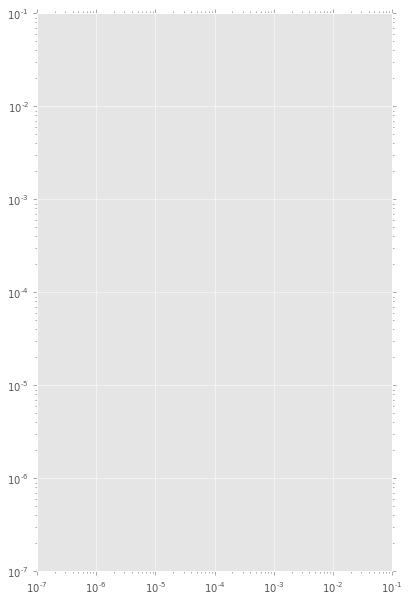

In [22]:
plt.figure(figsize=(14, 10))

subplot = 1
for rtype in ['LL']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam, 25.0)
        plt.subplot(1, 2, subplot)
        
        fig3 = run_jensen2005_fig3_findamp(model, rtype, jensen2005[ename][rtype][:, 0])

        plt.loglog(jensen2005[ename][rtype][:, 0], fig3['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')
        plt.loglog(jensen2005[ename][rtype][:, 0], jensen2005[ename][rtype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        
        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='lower left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.01, 100)
        if subplot > 2:
            plt.xticks(np.array([0.01, 0.1, 1, 10, 100]) / 1000, [0.01, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.01, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1
plt.savefig('jensen2005_fig3.png')